SOLUTION ARCHITECTURE

1. Assign "popularity" score to each comment by weighting others' opinions of each comment. Filter highly unpopular opinion. 

2. Vectorize each thought using BERT and cluster using DBSCAN to optimize diversity of opinion. 

3. Determine most popular and most relevant thoughts from each cluster to present to moderator. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# BERT vectorization
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

# Clustering
from sklearn.cluster import DBSCAN

C:\Users\bjane\miniconda3\envs\remesh-bert-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


The question posed is:

What features do you like about the social media platforms that you use? 

How do we summarize the participants answers to the moderator? 

In [2]:
# Import relevant data. 
thoughts = pd.read_csv('thoughts.csv')
binary_choices = pd.read_csv('binary_choices.csv')
agreements = pd.read_csv('agreements.csv')

# Import and Preview Data

## Comments

In [3]:
# Preview data. 
thoughts.head(60)

,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by other people.
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind of an audience my videos have and how people access them
3,3,5,Being able to mute/block people. It helps keep the feed clean
4,4,25,Being able to share content
5,5,34,"Ease of use, popularity. There is much that you can do."
6,6,6,Blocking
7,7,37,Few. Most of it is useless
8,8,0,I love seeing other people's pictures and being able to communicate easily
9,9,27,The ability to set my profile to private.


Common themes from initial look:
* Easy to use and network effect (popular)
* Control - blocking / unfollowing / muting / filtering / privacy
* Built-in apps (audio/video chat, sending/receiving money, "stories")
* Friends/family connection
* Nothing to contribute (negative impression) - possibly use sentiment model to remove these comments; tell the 'audience' that X proportion of users are not in favor of social media; idx (7,11,20) - how many people agree with these statements?
* Photos/pictures

## Binary Choices

In [4]:
# Preview data. 
binary_choices.head(60)

,respondent_id,thought_a_id,thought_b_id,label
0,32,20,14,A
1,29,19,21,A
2,37,6,19,A
3,32,35,5,A
4,37,8,6,B
5,32,14,18,B
6,32,11,16,A
7,32,6,32,B
8,32,3,38,B
9,32,1,8,A


In [5]:
# Preview data. 
binary_choices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   respondent_id  147 non-null    int64 
 1   thought_a_id   147 non-null    int64 
 2   thought_b_id   147 non-null    int64 
 3   label          147 non-null    object
dtypes: int64(3), object(1)
memory usage: 4.7+ KB


## Agreements

In [6]:
# preview data
agreements.head(60)

,respondent_id,thought_id,label
0,32,7,Disagree
1,37,3,Agree
2,37,1,Disagree
3,37,14,Disagree
4,37,19,Disagree
5,24,4,Agree
6,32,39,Agree
7,37,38,Disagree
8,6,18,Agree
9,6,1,Disagree


# Assign Popularity Score to Each Comment Using Meta Data

In order to best understand how strong a particular opinion is amongst the entire audience we will assign a score to each comment. This score will be based on how many agreements and preferences a thought receives. 

In [7]:
thoughts

,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by other people.
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind of an audience my videos have and how people access them
3,3,5,Being able to mute/block people. It helps keep the feed clean
4,4,25,Being able to share content
5,5,34,"Ease of use, popularity. There is much that you can do."
6,6,6,Blocking
7,7,37,Few. Most of it is useless
8,8,0,I love seeing other people's pictures and being able to communicate easily
9,9,27,The ability to set my profile to private.


In [8]:
# Add column showing respondent thought preference. 
binary_choices['thought_preference'] = binary_choices.apply(lambda row: row['thought_a_id'] if row['label'] == 'A' else row['thought_b_id'], axis=1)

In [9]:
# Iterate through thoughts df and show if thought is shared by others. 
for idx, row in thoughts.iterrows():
    # Identify thought id. 
    thought_id = thoughts.loc[idx,'id']
    
    # Agreements popularity
    
    # Count total agreement proposals and agreements.
    total_proposed_agreements = len(agreements[agreements['thought_id'] == thought_id])
    total_agreements = len(agreements[(agreements['thought_id'] == thought_id) &
                                      (agreements['label'] == 'Agree')])
    
    # Create agreement popularity score and add to thoughts dataframe
    agreement_popularity_score = total_agreements / total_proposed_agreements
    
    # Binary choice popularity
    
    # Count total binary choice proposals and preferences. 
    total_proposed_preferences = len(binary_choices[binary_choices['thought_a_id'] == thought_id]) + \
                                 len(binary_choices[binary_choices['thought_b_id'] == thought_id])
    
    total_preferences = len(binary_choices[binary_choices['thought_preference'] == thought_id])
    
    # Create binary choice popularity score and add to thoughts dataframe. 
    binary_choice_popularity_score = total_preferences / total_proposed_preferences
    
    # Add binary choice popularity score to thoughts dataframe
    binary_choice_popularity_score = total_preferences / total_proposed_preferences
    
    # Assign popularity score weights.
    binary_popularity_weight = total_proposed_preferences / (total_proposed_preferences + total_proposed_agreements)
    agreement_popularity_weight = total_proposed_agreements / (total_proposed_preferences + total_proposed_agreements)
    
    # Add popularity score to thoughts df
    thoughts.loc[idx,'popularity'] = binary_popularity_weight*binary_choice_popularity_score + \
                                     agreement_popularity_weight*agreement_popularity_score

In [10]:
# Preview most popular comments. 
thoughts.sort_values(by='popularity', ascending=False)

,id,respondent_id,text,popularity
29,29,26,"connection, simplicity, convenience",0.916667
18,18,31,Seeing pictures and posts from my friends/family,0.888889
32,32,28,I like how I can see the latest posts from the people I follow.,0.857143
25,25,32,Being able to keep in contact with others,0.750000
26,26,1,"Ability to see updates in real time, ability to keep up with friends/family.",0.750000
37,37,40,"Meet and chat with new people, especially around weird hobbies, and learn a lot more about those hobbies or weird interests. Like hot sauce, or russian literature, etc.",0.750000
15,15,21,I enjoy the stories features a lot.,0.722222
3,3,5,Being able to mute/block people. It helps keep the feed clean,0.722222
17,17,30,it allows me to easily keep in touch with people I care about,0.687500
22,22,9,It's very easy to view my friend's posts and to respond to them.,0.687500


## Drop Very Unpopular Thoughts

In [11]:
# Drop unpopular opinions. 
thoughts = thoughts[thoughts['popularity'] >= 0.5]

# Sentence Vectorization with Clustering

## BERT Vectorization

In [12]:
# create BERT embeddings for each thought
vectorizer = Vectorizer()
vectorizer.bert(thoughts['text'])
vectors = vectorizer.vectors

In [13]:
vectors.shape

(29, 768)

## DBSCAN Clustering

Because we have a very small dataset and we'd like to find as many unique ideas as possible, we are going to optimize epsilon to maximize the number of clusters. 

### Optimize Epsilon

In [14]:
# initialize esp/# classes dictionary
n_classes = {}

for i in (np.arange(0.001, 0.1, 0.001)):
    # fit DBSCAN
    dbscan = DBSCAN(eps=i, min_samples=2, metric='cosine').fit(vectors)
    
    # identify # of clusters
    numberClusters = len(np.unique(dbscan.labels_))
     
    # append # clusters to dictionary
    n_classes.update({i: numberClusters})

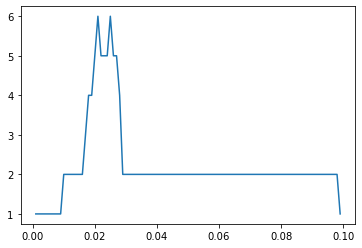

In [15]:
# plot eps vs. n clusters
eps = n_classes.keys()
numberClasses = n_classes.values()

plt.plot(eps,numberClasses)

### Implement DBSCAN with Optimized Epsilon

In [16]:
# optimized dbscan
dbscanOptimized = DBSCAN(eps=0.022, min_samples=2, metric='cosine').fit(vectors)

In [17]:
# total classes
len(np.unique(dbscanOptimized.labels_))

5

In [18]:
# Total thoughts relating to each class
pd.Series(dbscanOptimized.labels_).value_counts()

-1    16
 1     5
 0     4
 2     2
 3     2
dtype: int64

### Check Out Clusters

In [19]:
# Add clusters and cluster vector to thoughts df. 
thoughts['cluster'] = dbscanOptimized.labels_
thoughts['vector'] = [vector for vector in vectors]

<ipython-input-19-bdb0d3405207>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thoughts['cluster'] = dbscanOptimized.labels_
<ipython-input-19-bdb0d3405207>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thoughts['vector'] = [vector for vector in vectors]


In [20]:
# Define cluster center and add to df. 
cluster_center = thoughts[['cluster', 'vector']].groupby('cluster')['vector'].apply(lambda x: np.mean(x)).reset_index().rename(columns={'vector': 'cluster_center'})
thoughts = thoughts.merge(cluster_center, on='cluster')

### Find Most Relevant and Most Popular Thoughts from Each Cluster

In [21]:
# Add cosine similarity between each cluster center and thought vector. 
thoughts['cosine_similarity'] = thoughts.apply(lambda row: spatial.distance.cosine(row['vector'], row['cluster_center']), axis=1)

In [22]:
# Find most relevant thoughts for each cluster. 
most_relevant_thoughts = thoughts[['text', 'cluster', 'cosine_similarity']].groupby('cluster').max()

In [23]:
# Find most popular thought for each cluster.
thoughts = thoughts.sort_values(by='popularity', ascending=False)
most_popular_thoughts = thoughts[['text', 'popularity', 'cluster']].groupby('cluster').first()

In [24]:
# Append most popular and relevant thoughts, drop duplicates, and sort by popularity
summary_thoughts = pd.concat([most_popular_thoughts[['text']], most_relevant_thoughts[['text']]]).drop_duplicates()
summary_thoughts = summary_thoughts.merge(thoughts[['text', 'popularity']], right_on='text', left_on='text')
summary_thoughts = summary_thoughts.sort_values(by='popularity', ascending=False).reset_index(drop=True)

In [25]:
summary_thoughts

,text,popularity
0,"connection, simplicity, convenience",0.916667
1,Seeing pictures and posts from my friends/family,0.888889
2,I like how I can see the latest posts from the people I follow.,0.857143
3,Being able to keep in contact with others,0.750000
4,it allows me to easily keep in touch with people I care about,0.687500
5,It's very easy to view my friend's posts and to respond to them.,0.687500
6,Easy access is just about the only thing.,0.681818
7,nothing to be honest stands out--it's just adequate.,0.529412
8,Upvoting/Downvoting content. Ability to easily filter what I see,0.500000


In [26]:
thoughts

,id,respondent_id,text,popularity,cluster,vector,cluster_center,cosine_similarity
26,29,26,"connection, simplicity, convenience",0.916667,2,"[0.10102062, -0.276012, 0.27324286, -0.09377621, -0.24771671, -0.17526713, 0.11928348, 0.09050315, 0.14628586, -0.15928784, -0.0040675886, 0.14806394, 0.11605144, -0.015719578, 0.0065838676, 0.10624676, 0.09090104, 0.093290694, -0.033864394, -0.23907223, 0.11727863, 0.16738945, 0.28764144, 0.073065534, -0.14989288, 0.057122927, 0.083055556, 0.30522913, 0.15969425, 0.012746392, -0.098496586, 0.103067234, -0.23491701, -0.20653632, 0.10500847, 0.22095183, 0.28859544, 0.084176965, 0.16138276, -0.06576767, -0.20412496, -0.040984854, 0.23933804, 0.14349474, -0.07215116, -0.12258759, -2.5002003, 0.4535299, -0.4243121, -0.27333337, 0.080605045, 0.21803579, -0.12043001, 0.18957466, 0.010924742, 0.47808886, -0.19356439, 0.0033710748, 0.32924053, 0.14189358, 0.070027694, 0.051955312, -0.08086963, 0.23478885, -0.1453321, 0.5308646, -0.3240439, 0.52534527, -0.56700623, 0.39528134, -0.25500768, -0.076332495, 0.008335933, 0.10700314, 0.089304335, 0.25802892, -0.058251, -0.15463445, 0.1345603, 0.23144445, -0.22835271, -0.07780042, 0.16135158, -0.14092585, 0.279477, 0.1295211, 0.14894061, 0.03034557, 0.17444476, 0.44350752, 0.18344408, -0.17372496, 0.39009076, 0.3332452, 0.1752846, 0.1261267, -0.06828047, -0.232556, 0.076848485, 0.19141209, ...]","[0.09702708, -0.27022046, 0.2702227, -0.11645454, -0.26123035, -0.2117193, 0.11845113, 0.12345475, 0.121247865, -0.17054911, 0.01584418, 0.09878115, 0.109256424, -0.0003923485, 0.023398098, 0.07659943, 0.090580225, 0.11131182, -0.008940976, -0.24337545, 0.11539277, 0.16923234, 0.2914414, 0.09701342, -0.23421654, 0.04504386, 0.075065985, 0.35011178, 0.21887228, 0.037815373, -0.05000499, 0.10045043, -0.23625863, -0.13191742, 0.0876231, 0.28522986, 0.2432042, 0.076255485, 0.1597905, -0.034277402, -0.24760027, -0.019829787, 0.23960917, 0.11685686, -0.09039165, -0.11809068, -2.5286453, 0.42713976, -0.37642342, -0.28239894, 0.07866207, 0.24477072, -0.11181521, 0.1470744, 0.005707767, 0.48400497, -0.15619498, 0.015295435, 0.33013195, 0.19957122, 0.06106074, 0.03504452, -0.18975112, 0.21552567, -0.14751367, 0.5766659, -0.36547184, 0.5231733, -0.62071204, 0.35273057, -0.30342758, -0.03079502, 0.04530688, 0.13711795, 0.094029725, 0.31250682, -0.076097816, -0.14781179, 0.08984644, 0.2043392, -0.2374183, -0.1131471, 0.13530001, -0.14766204, 0.2746849, 0.15116546, 0.16397989, 0.009743846, 0.20474005, 0.43363538, 0.16108832, -0.18669617, 0.4490511, 0.36174995, 0.17682216, 0.18378446, -0.08557717, -0.19473985, 0.08253923, 0.16742069, ...]",0.005429
5,18,31,Seeing pictures and posts from my friends/family,0.888889,-1,"[-0.04358504, -0.30345935, 0.3266341, -0.1768625, -0.32403108, -0.15235183, 0.1838808, 0.14390045, -0.04533927, -0.0067017376, -0.030841848, 0.021555087, 0.07291043, 0.054302823, -0.100030534, -0.08929712, -0.03343527, 0.16867274, 0.024147235, -0.25365004, 0.03245815, 0.10577776, 0.2401681, -0.0591808, -0.13342646, 0.06966886, 0.09417515, 0.2590071, 0.16457644, -0.16279466, 0.006785957, 0.08174026, 0.02722846, -0.041687906, -0.016425138, 0.009781696, 0.100833565, 0.03279581, 0.1623468, -0.1702308, -0.057618205, -0.12233578, 0.15652072, 0.05736, 0.11513978, -0.23231237, -2.4113877, 0.29959702, -0.308474, -0.20070416, 0.33935243, 0.19174674, 0.13131006, 0.16461408, 0.13919574, 0.29646298, -0.059126943, 0.13515821, 0.045588918, 0.1881599, 0.15101251, 0.06320143, 0.082771815, 0.107980035, -0.1769098, 0.301381, -0.09566888, 0.3911873, -0.33665487, 0.2189614, -0.095977426, -0.08534228, 0.055884175, 0.08570778, 0.028359694, 0.17247854, -0.052209564, -0.0026597902, -0.10337444, 0.2022866, -0.17185965, -0.025241183, 0.14094223, -0.0859034, 0.13618082, 0.072569065, 0.35555774, 0.095858626, 0.16363046, 0.587767, 0.05654446, -0.17482066, 0.33590388, 0.22600067, 0.26584244, -0.121249385, -0.18258168, -0.15916812, 0.13770771, 0.176193, ...]","[-0.04594625, -0.2983566, 0.1859248

In [27]:
# SUMMARY

# CONNECTING WITH FRIENDS/FAMILY
# EASY TO USE
# NOTHING SPECIAL AT ALL
# USER CONTROL (FILTERING/VOTING)